In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import regex as re

In [42]:
from framefinder import framelabels

candidate_labels = [
    "Economic: costs, benefits, or other financial implications",
    "Capacity and resources: availability of physical, human or financial resources, and capacity of current systems",
    "Morality: religious or ethical implications",
    "Fairness and equality: balance or distribution of rights, responsibilities, and resources",
    "Legality, constitutionality and jurisprudence: rights, freedoms, and authority of individuals, corporations, and government",
    "Policy prescription and evaluation: discussion of specific policies aimed at addressing problems",
    "Crime and punishment: effectiveness and implications of laws and their enforcement",
    "Security and defense: threats to welfare of the individual, community, or nation",
    "Health and safety: health care, sanitation, public safety",
    "Quality of life: threats and opportunities for the individual’s wealth, happiness, and well-being",
    "Cultural identity: traditions, customs, or values of a social group in relation to a policy issue",
    "Public opinion: attitudes and opinions of the general public, including polling and demographics",
    "Political: considerations related to politics and politicians, including lobbying, elections, and attempts to sway voters",
    "External regulation and reputation: international reputation or foreign policy of the U.S.",
    "Other: any coherent group of frames not covered by the above categories",
]

framing_labels = framelabels.FramingLabels("facebook/bart-large-mnli", candidate_labels)

In [43]:
from framefinder import framedimensions

dimensions = [
    "Care: ...acted with kindness, compassion, or empathy, or nurtured another person.",
    "Harm: ...acted with cruelty, or hurt or harmed another person/animal and caused suffering.",
    "Fairness: ...acted in a fair manner, promoting equality, justice, or rights.",
    "Cheating: ...was unfair or cheated, or caused an injustice or engaged in fraud.",
    "Loyalty: ...acted with fidelity, or as a team player, or was loyal or patriotic.",
    "Betrayal: ...acted disloyal, betrayed someone, was disloyal, or was a traitor.",
    "Authority: ...obeyed, or acted with respect for authority or tradition.",
    "Subversion: ...disobeyed or showed disrespect, or engaged in subversion or caused chaos.",
    "Sanctity: ...acted in a way that was wholesome or sacred, or displayed purity or sanctity.",
    "Degredation: ...was depraved, degrading, impure, or unnatural.",
]
pole_names = [
    ("Care", "Harm"),
    ("Fairness", "Cheating"),
    ("Loyalty", "Betrayal"),
    ("Authority", "Subversion"),
    ("Sanctity", "Degredation"),
]
base_model = 'all-mpnet-base-v2'
framing_dimensions = framedimensions.FramingDimensions(base_model, dimensions, pole_names)

In [44]:
import requests

def read_files(filenames):
    files = []
    for file_name in filenames:
        with open("articles/" + file_name, 'r',encoding="utf8") as file:
            files.append(file.read())
    return files

def clean_string(text):
    text = text.split("==See also==")[0] # remove everything after "See also"
    text = re.sub(r'\{\{.*}}', '', text) # remove {{}}
    text = re.sub(r'&lt;ref.*?&lt;/ref>', "", text) # remove <ref>...</ref>
    text = re.sub(r"&lt;ref.*/>", "", text) # remove <ref ... />
    text = re.sub(r"==+", "", text) # remove ==, ===, ====, ...
    text = re.sub(r"'+", "", text) # remove ''', '''', ...
    text = re.sub(r'\[\[File:(?:\[\[[^\]]*?\]\]|.)*?\]\]', "", text)
    text = text.replace(r"[[", "").replace("]]", "") # remove [[ and ]]
    text = re.sub(r'\n+', '\n', text) # replace multiple newlines with one
    return text

def extract_source(text):
    text = text.split('You can view and copy the source of this page:</div><textarea readonly="" accesskey="," id="wpTextbox1" cols="80" rows="25" style="" class="mw-editfont-monospace" lang="en" dir="ltr" name="wpTextbox1">')[1]
    return text.split('</textarea><')[0]
    
def fetch_wiki_articles(articles): # ? might not work for all articles, need to test
    article_texts = []
    for article in articles:
        response = requests.get(f"https://en.wikipedia.org/w/index.php?title={article}&action=edit")
        text = extract_source(response.text)
        article_texts.append(clean_string(text))
    return article_texts

In [45]:
# fetch articles directly from wikipedia
article_titles = ["Anti-abortion_movements", "Abortion-rights_movements"]
articles = fetch_wiki_articles(article_titles)

# local files
# articles = read_files(article_titles)
# articles = [clean_string(article) for article in articles]

# for article in articles:
#    print(article)

# todo article cleaning
# todo maybe split articles into paragraphs

100%|██████████| 2/2 [00:00<00:00, 16611.10it/s]


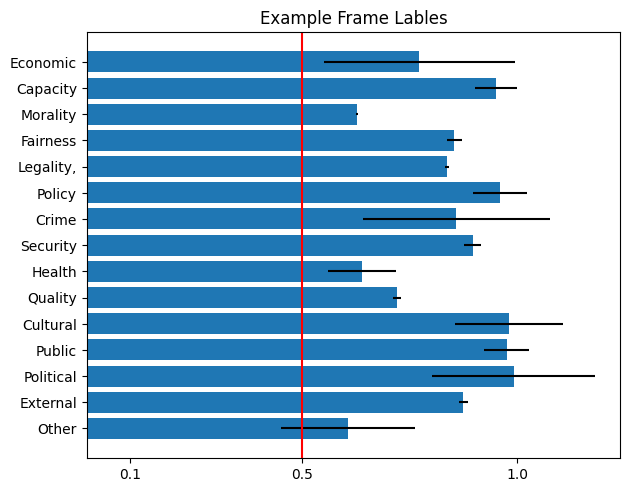

In [46]:
labels = framing_labels(articles)
labels_df = pd.DataFrame(labels)
_, ax = framing_labels.visualize(labels_df.mean().to_dict(), xerr=labels_df.sem())
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
plt.xticks([0.1, 0.5, 1])
plt.title("Example Frame Lables")
plt.axvline(0.5, color="red")
plt.show()

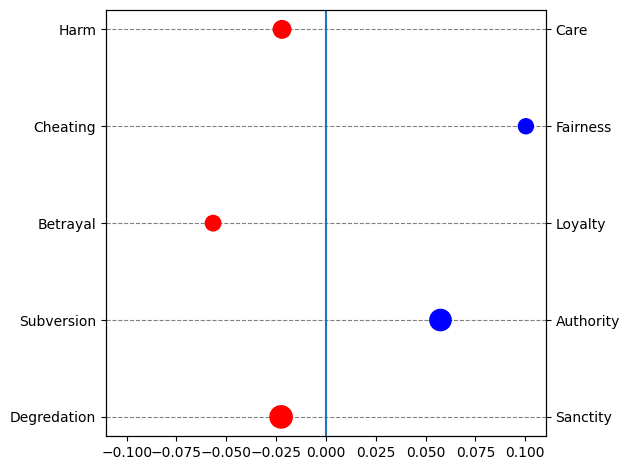

In [47]:
dimensions = framing_dimensions(articles)
dimensions_df = pd.DataFrame(dimensions)
g = framing_dimensions.visualize(dimensions_df)
g.axes[0].set_axisbelow(True)
g.axes[0].yaxis.grid(color='gray', linestyle='dashed')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()